In [1]:
import numpy as np
import MDAnalysis as mda
import importlib
import XS_calc
from XS_calc import *

import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

In [2]:
importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc

In [3]:
# This would be a typical use case
U = mda.Universe('data/Ala10.pdb')
traj = Trajectory(U, selection='protein')
env = Environment()
mea = Measurement(q = np.linspace(0.03, 0.8, num=200))
# XS = traj_calc(traj, env, mea)

# Do something with XS. E.g. fitting etc.


The protein has 104 atoms


In [4]:
sel = U.select_atoms('protein')

In [5]:
sel.positions

array([[ -0.132,   2.45 ,  -0.112],
       [  0.22 ,   3.108,  -0.747],
       [ -0.767,   3.067,   0.352],
       [ -0.701,   1.208,  -0.598],
       [ -1.037,   0.692,   0.19 ],
       [ -1.858,   1.545,  -1.491],
       [ -2.05 ,   2.639,  -1.501],
       [ -1.653,   1.224,  -2.536],
       [ -2.782,   1.037,  -1.14 ],
       [  0.323,   0.385,  -1.361],
       [  1.392,   0.057,  -0.853],
       [  0.027,   0.038,  -2.578],
       [ -0.836,   0.3  ,  -2.997],
       [  0.958,  -0.756,  -3.385],
       [  1.105,  -1.623,  -2.909],
       [  0.335,  -1.033,  -4.721],
       [ -0.467,  -0.298,  -4.949],
       [  1.096,  -0.969,  -5.529],
       [ -0.115,  -2.049,  -4.739],
       [  2.28 ,  -0.029,  -3.565],
       [  2.967,  -0.186,  -4.572],
       [  2.659,   0.772,  -2.614],
       [  2.109,   0.903,  -1.796],
       [  3.918,   1.515,  -2.71 ],
       [  3.862,   2.1  ,  -3.519],
       [  4.071,   2.378,  -1.493],
       [  5.054,   2.208,  -1.002],
       [  4.007,   3.455,  -

In [6]:
traj.SASA_calc_traj(env)

print(traj.Frames[0].SASA)
np.shape(traj.Frames[0].SASA)

[0.005 0.165 0.33  0.01  0.215 0.05  0.205 0.1   0.305 0.03  0.18  0.
 0.02  0.005 0.12  0.04  0.21  0.17  0.295 0.025 0.1   0.    0.    0.
 0.14  0.045 0.19  0.26  0.105 0.015 0.09  0.    0.    0.005 0.14  0.055
 0.12  0.205 0.255 0.015 0.1   0.    0.    0.005 0.135 0.045 0.18  0.295
 0.1   0.015 0.1   0.    0.    0.    0.15  0.045 0.125 0.21  0.245 0.01
 0.105 0.    0.    0.005 0.125 0.045 0.185 0.28  0.105 0.01  0.09  0.
 0.    0.005 0.145 0.05  0.12  0.21  0.235 0.005 0.1   0.    0.    0.
 0.195 0.05  0.18  0.245 0.21  0.02  0.175 0.    0.    0.005 0.19  0.04
 0.185 0.315 0.08  0.075 0.335 0.    0.355 0.   ]


(104,)

In [7]:
frame.mol.n_atoms

NameError: name 'frame' is not defined

In [23]:

traj = Trajectory(U, selection='protein', match_FoXS=False)
frame = traj.Frames[0]
env = Environment(c2=2)
mea = Measurement(q = np.linspace(0.00, 0.5, num=501))
frame.SASA_calc(env)

FF_q = FF_calc(frame, env, mea)

# an i by j matrix of distances between all atoms
d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))

XS = np.zeros(np.shape(mea.q))
for i in np.arange(frame.mol.n_atoms):
    for j in np.arange(i+1, frame.mol.n_atoms):
        qd = mea.q * d_ij[i,j]
        XS += 2 * FF_q[i] * FF_q[j] * np.sinc(qd / np.pi)
    XS += FF_q[i] ** 2

The protein has 104 atoms


27711.952573917893


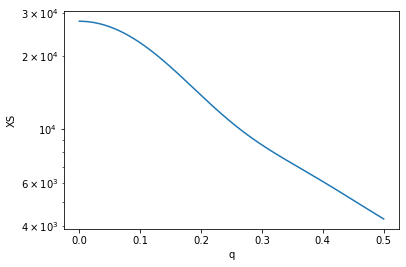

In [24]:
print(XS[0])
plt.figure()
plt.plot(mea.q, XS)
plt.ylabel('XS')
plt.xlabel('q')
plt.yscale('log')
plt.show()

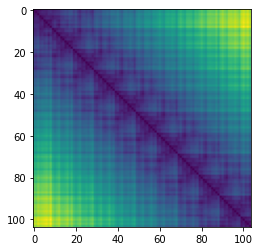

In [47]:
plt.imshow(d_ij)
plt.show()

In [4]:
def frame_XS_calc(frame, env, mea, ignoreSASA=False): # Calculate the X-ray scattering of a frame
    if not ignoreSASA:
        # Get the SASA calculated if not done
        frame.SASA_calc(env)

    # Calculate adjusted form factors as a table.
    FF_q = FF_calc(frame, env, mea)
    
    # an i by j matrix of distances between all atoms
    d_ij = np.sqrt(np.sum((frame.xyz[None,:,:]-frame.xyz[:,None,:])**2, axis=2))

    # Calculate scattering signal XS
    XS = np.zeros(np.shape(mea.q))
    for i in np.arange(frame.mol.n_atoms):
        for j in np.arange(frame.mol.n_atoms-1)+1:
            qd = mea.q * d_ij[i,j]
            XS += 2 * FF_q[i] * FF_q[j] * np.sinc(qd / np.pi)
        XS += FF_q[i] ** 2

    return XS

In [48]:
XS = frame_XS_calc(traj.Frames[0], env, mea)

In [49]:
XS[0]

8765.972537544314

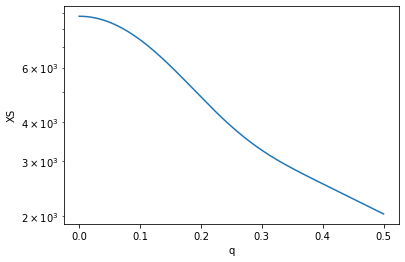

In [50]:
plt.figure()
plt.plot(mea.q, XS)
plt.ylabel('XS')
plt.xlabel('q')
plt.yscale('log')
plt.show()

In [12]:
plt.plot(np.log(mea.q),np.log(XS))
plt.ylabel('Log(XS)')
plt.xlabel('Log(q)')
plt.show()